In [3]:
import numpy as np
from functools import partial

import torch
from torch import nn
from torch.nn import functional as F

import sys
sys.path.append('/content/drive/MyDrive/CS4248_project-main/codes')

%load_ext autoreload
%autoreload 2
%aimport utils


import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# !unzip /content/drive/MyDrive/CS4248_project-main.zip


Mounted at /content/drive


### Load Data
**obj_len** controls the overall length of texts. <br>Assume A is a text. If len(A) < obj_len, it will be padded. Else, it will be truncated.<br>
Change the parameters of the dataloader as you wish.


In [5]:
data = utils.load_data(obj_len=1000,batch_size=64)

train_iter = data['train_iter']
val_iter = data['val_iter']
test_iter = data['test_iter']
embed_matrix_word2vec = data['word2vec']
embed_matrix_glove = data['glove']

In [6]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim,
                 bi_dir:bool, n_layers,
                 pretrained_embed):
        """bi_dir: Bi-directinoal if True"""
        """pretrained_embed is the embedding matrix"""
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_dim)
        self.embedding.weight.data.copy_(pretrained_embed)
        self.embedding.weight.requires_grad = False   # freeze word embeddings

        self.encoder = nn.GRU(embed_dim, hidden_dim, num_layers=n_layers, bidirectional=bi_dir)
        self.num_dir = 1 + bi_dir
        self.decoder = nn.Linear(hidden_dim * self.num_dir, output_dim)   # times 2 if the model is bi-directional

    def forward(self, inputs):
        # the expected input shape of RNN models are: (seq_len, batch_size, feature_dim)
        # thus we need to transpose the inputs
        embedding = self.embedding(inputs.T)  # shape: (seq_len, batch_size, embed_dim)

        self.encoder.flatten_parameters()
        _, hidden = self.encoder(embedding)  # shape: (n_layers, batch_size, hidden_dim)
        if self.encoder.bidirectional:
            outputs = torch.cat((hidden[-2],hidden[-1]),dim=1)
        else:
            outputs = hidden[-1]
        return self.decoder(outputs)

In [7]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, bi_dir: bool, n_layers, pretrained_embed):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight.data.copy_(pretrained_embed)
        self.embedding.weight.requires_grad = False  # freeze word embeddings

        self.encoder = nn.RNN(embed_dim, hidden_dim, num_layers=n_layers, bidirectional=bi_dir)
        self.num_dir = 2 if bi_dir else 1
        self.decoder = nn.Linear(hidden_dim * self.num_dir, output_dim)

    def forward(self, inputs):
        embedding = self.embedding(inputs.T)  # transpose inputs to shape: (seq_len, batch_size, embed_dim)

        self.encoder.flatten_parameters()
        _, hidden = self.encoder(embedding)  # output shape: (n_layers * num_dir, batch_size, hidden_dim)
        if self.encoder.bidirectional:
            outputs = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            outputs = hidden[-1]

        return self.decoder(outputs)


In [8]:
# class LSTMModel(nn.Module):
#     def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, bi_dir: bool, n_layers, pretrained_embed):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, embed_dim)
#         self.embedding.weight.data.copy_(pretrained_embed)
#         self.embedding.weight.requires_grad = False  # freeze word embeddings

#         self.encoder = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, bidirectional=bi_dir, dropout=0.5 if n_layers > 1 else 0)
#         self.num_dir = 2 if bi_dir else 1
#         self.decoder = nn.Linear(hidden_dim * self.num_dir, output_dim)

#     def forward(self, inputs):
#         embedding = self.embedding(inputs.T)  # transpose inputs to shape: (seq_len, batch_size, embed_dim)

#         self.encoder.flatten_parameters()
#         _, (hidden, _) = self.encoder(embedding)  # LSTM returns hidden and cell states
#         if self.encoder.bidirectional:
#             outputs = torch.cat((hidden[-2], hidden[-1]), dim=1)
#         else:
#             outputs = hidden[-1]

#         return self.decoder(outputs)
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, bi_dir: bool, n_layers, pretrained_embed, dropout_rate=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight.data.copy_(pretrained_embed)
        self.embedding.weight.requires_grad = False  # freeze word embeddings

        self.encoder = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, bidirectional=bi_dir, dropout=dropout_rate if n_layers > 1 else 0)
        self.num_dir = 2 if bi_dir else 1
        self.dropout = nn.Dropout(dropout_rate)
        self.decoder = nn.Linear(hidden_dim * self.num_dir, output_dim)

    def forward(self, inputs):
        embedding = self.embedding(inputs.T)  # transpose inputs to shape: (seq_len, batch_size, embed_dim)
        embedding = self.dropout(embedding)

        self.encoder.flatten_parameters()
        output, (hidden, _) = self.encoder(embedding)  # LSTM returns output, hidden and cell states
        if self.encoder.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        else:
            hidden = self.dropout(hidden[-1])

        return self.decoder(hidden)


In [9]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class MLPModel(nn.Module):
#     def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, pretrained_embed, dropout_rate=0.5):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, embed_dim)
#         self.embedding.weight.data.copy_(pretrained_embed)
#         self.embedding.weight.requires_grad = False  # freeze word embeddings

#         self.dropout = nn.Dropout(dropout_rate)

#         # Assuming the first layer should match the actual flattened input size
#         self.input_dim = embed_dim *   # Adjust this based on actual calculation (seq_len * embed_dim)
#         self.hidden_dim = hidden_dim

#         # Initialize the first layer with the correct input dimension
#         self.layers = nn.ModuleList([nn.Linear(self.input_dim, self.hidden_dim)])
#         self.layers.extend([
#             nn.Linear(self.hidden_dim, self.hidden_dim) for _ in range(n_layers - 2)
#         ])
#         self.layers.append(nn.Linear(self.hidden_dim, output_dim))

#     def forward(self, inputs):
#         # Embedding input shape: (seq_len, batch_size)
#         embedded = self.embedding(inputs).transpose(0, 1)
#         batch_size = embedded.size(0)

#         # Flatten the embeddings
#         mlp_input = embedded.reshape(batch_size, -1)
#         mlp_input = self.dropout(mlp_input)

#         # Pass through each MLP layer
#         output = mlp_input
#         for layer in self.layers:
#             output = F.relu(layer(output))
#         output = self.layers[-1](output)  # No ReLU for the output layer

#         return output


SyntaxError: invalid syntax (<ipython-input-9-a028e462a45c>, line 15)

In [10]:
def init_weight(layer):
    """initialize the weight of a layer"""
    """Use Xavier initialization"""
    if type(layer) == nn.Linear:
        nn.init.xavier_uniform_(layer.weight)
    if type(layer) == nn.GRU:
        for param_name in layer._flat_weights_names:
            if "weight" in param_name:
                nn.init.xavier_uniform_(layer._parameters[param_name])

In [13]:
fixed_params = {
    "vocab_size":embed_matrix_glove.shape[0],
    "embed_dim":embed_matrix_glove.shape[1],
    "output_dim":4
}

gru = partial(GRUModel, **fixed_params)
rnn = partial(RNNModel, **fixed_params)
lstm = partial(LSTMModel, **fixed_params)
# mlp = partial(MLPModel, **fixed_params)

In [14]:
print(embed_matrix_glove.shape[1])

300


# Glove

In [17]:
glove_params = {
    "hidden_dim":64,
    "bi_dir":True,
    "n_layers":1,
    "pretrained_embed":embed_matrix_glove
}
mlp_prams = {
    "hidden_dim":64,
    "n_layers":1,
    "pretrained_embed":embed_matrix_glove
}

rnn_glove = rnn(**glove_params)
rnn_glove.apply(init_weight)    # Xavier intialization
lstm_glove = lstm(**glove_params)
lstm_glove.apply(init_weight)
gru_glove = gru(**glove_params)
gru_glove.apply(init_weight)
# mlp_glove = mlp(**mlp_prams)
# mlp_glove.apply(init_weight)

GRUModel(
  (embedding): Embedding(25002, 300)
  (encoder): GRU(300, 64, bidirectional=True)
  (decoder): Linear(in_features=128, out_features=4, bias=True)
)

set **verbose** == True if you wanna monitor the training process.

CUDA is available. Training on GPU.


  5%|▌         | 1/20 [00:19<06:14, 19.73s/it]

epoch 0   train_f1: 0.852, val_f1: 0.844



 10%|█         | 2/20 [00:39<05:53, 19.61s/it]

epoch 1   train_f1: 0.883, val_f1: 0.879



 15%|█▌        | 3/20 [00:59<05:40, 20.04s/it]

epoch 2   train_f1: 0.928, val_f1: 0.922



 20%|██        | 4/20 [01:21<05:30, 20.68s/it]

epoch 3   train_f1: 0.954, val_f1: 0.949



 25%|██▌       | 5/20 [01:43<05:16, 21.13s/it]

epoch 4   train_f1: 0.959, val_f1: 0.954



 30%|███       | 6/20 [02:04<04:55, 21.10s/it]

epoch 5   train_f1: 0.970, val_f1: 0.964



 35%|███▌      | 7/20 [02:25<04:33, 21.06s/it]

epoch 6   train_f1: 0.972, val_f1: 0.964



 40%|████      | 8/20 [02:46<04:13, 21.15s/it]

epoch 7   train_f1: 0.984, val_f1: 0.974



 45%|████▌     | 9/20 [03:08<03:55, 21.40s/it]

epoch 8   train_f1: 0.974, val_f1: 0.967



 50%|█████     | 10/20 [03:30<03:35, 21.52s/it]

epoch 9   train_f1: 0.974, val_f1: 0.966



 55%|█████▌    | 11/20 [03:52<03:14, 21.60s/it]

epoch 10   train_f1: 0.987, val_f1: 0.977



 60%|██████    | 12/20 [04:14<02:53, 21.65s/it]

epoch 11   train_f1: 0.988, val_f1: 0.976



 65%|██████▌   | 13/20 [04:35<02:31, 21.69s/it]

epoch 12   train_f1: 0.988, val_f1: 0.977



 70%|███████   | 14/20 [04:57<02:10, 21.71s/it]

epoch 13   train_f1: 0.987, val_f1: 0.974



 75%|███████▌  | 15/20 [05:19<01:48, 21.76s/it]

epoch 14   train_f1: 0.993, val_f1: 0.980



 80%|████████  | 16/20 [05:41<01:26, 21.72s/it]

epoch 15   train_f1: 0.994, val_f1: 0.980



 85%|████████▌ | 17/20 [06:02<01:04, 21.54s/it]

epoch 16   train_f1: 0.995, val_f1: 0.982



 90%|█████████ | 18/20 [06:23<00:42, 21.41s/it]

epoch 17   train_f1: 0.994, val_f1: 0.979



 95%|█████████▌| 19/20 [06:44<00:21, 21.27s/it]

epoch 18   train_f1: 0.983, val_f1: 0.970



100%|██████████| 20/20 [07:05<00:00, 21.26s/it]

epoch 19   train_f1: 0.994, val_f1: 0.979



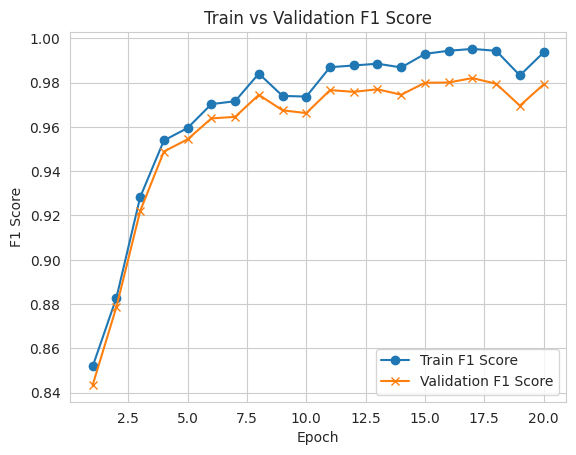

In [16]:
model = lstm_glove
utils.train(model, train_iter, val_iter,
            lr=1e-3, num_epochs=20, verbose=True)


In [18]:
utils.calculate_metric(model, test_iter, device="cuda")

0.5675047255348007

It's strange that the model performs very well on the validation set but performs poorly on the test set. I made sure that there's no data leakage except the vocabulary is derived on the union of training and validation set. The distribution of test data might be different from the training corpus.

In [19]:
# confusion matrix
utils.get_cm(model, test_iter, device="cuda")

array([[0.824     , 0.136     , 0.03333333, 0.00666667],
       [0.02159244, 0.47638327, 0.4925776 , 0.00944669],
       [0.11333333, 0.004     , 0.15333333, 0.72933333],
       [0.06711409, 0.00268456, 0.0147651 , 0.91543624]])

The model's terrible at predicting class 2 and 3

# Word2vec

In [20]:
word2vec_params = {
    "hidden_dim":64,
    "bi_dir":True,
    "n_layers":1,
    "pretrained_embed":embed_matrix_word2vec
}

gru_word2vec = rnn(**word2vec_params)
gru_word2vec.apply(init_weight)     # Xavier intialization
lstm_word2vec = lstm(**word2vec_params)
lstm_word2vec.apply(init_weight)
# mlp_word2vec = mlp(**word2vec_params)
# mlp_word2vec.apply(init_weight)

LSTMModel(
  (embedding): Embedding(25002, 300)
  (encoder): LSTM(300, 64, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=128, out_features=4, bias=True)
)

CUDA is available. Training on GPU.


  4%|▍         | 1/25 [00:20<08:17, 20.72s/it]

epoch 0   train_f1: 0.843, val_f1: 0.842



  8%|▊         | 2/25 [00:41<08:00, 20.88s/it]

epoch 1   train_f1: 0.843, val_f1: 0.833



 12%|█▏        | 3/25 [01:02<07:38, 20.83s/it]

epoch 2   train_f1: 0.864, val_f1: 0.865



 16%|█▌        | 4/25 [01:23<07:16, 20.78s/it]

epoch 3   train_f1: 0.811, val_f1: 0.803



 20%|██        | 5/25 [01:43<06:52, 20.64s/it]

epoch 4   train_f1: 0.791, val_f1: 0.792



 24%|██▍       | 6/25 [02:04<06:31, 20.61s/it]

epoch 5   train_f1: 0.762, val_f1: 0.760



 28%|██▊       | 7/25 [02:24<06:10, 20.56s/it]

epoch 6   train_f1: 0.826, val_f1: 0.825



 32%|███▏      | 8/25 [02:45<05:50, 20.63s/it]

epoch 7   train_f1: 0.913, val_f1: 0.906



 36%|███▌      | 9/25 [03:06<05:30, 20.65s/it]

epoch 8   train_f1: 0.931, val_f1: 0.924



 40%|████      | 10/25 [03:26<05:09, 20.66s/it]

epoch 9   train_f1: 0.887, val_f1: 0.884



 44%|████▍     | 11/25 [03:47<04:49, 20.67s/it]

epoch 10   train_f1: 0.913, val_f1: 0.908



 48%|████▊     | 12/25 [04:08<04:30, 20.77s/it]

epoch 11   train_f1: 0.934, val_f1: 0.928



 52%|█████▏    | 13/25 [04:29<04:11, 20.95s/it]

epoch 12   train_f1: 0.953, val_f1: 0.946



 56%|█████▌    | 14/25 [04:51<03:51, 21.05s/it]

epoch 13   train_f1: 0.956, val_f1: 0.948



 60%|██████    | 15/25 [05:12<03:31, 21.16s/it]

epoch 14   train_f1: 0.964, val_f1: 0.957



 64%|██████▍   | 16/25 [05:34<03:11, 21.27s/it]

epoch 15   train_f1: 0.969, val_f1: 0.960



 68%|██████▊   | 17/25 [05:55<02:50, 21.34s/it]

epoch 16   train_f1: 0.972, val_f1: 0.964



 72%|███████▏  | 18/25 [06:16<02:29, 21.36s/it]

epoch 17   train_f1: 0.966, val_f1: 0.959



 76%|███████▌  | 19/25 [06:38<02:07, 21.33s/it]

epoch 18   train_f1: 0.970, val_f1: 0.962



 80%|████████  | 20/25 [06:59<01:46, 21.29s/it]

epoch 19   train_f1: 0.980, val_f1: 0.970



 84%|████████▍ | 21/25 [07:20<01:25, 21.25s/it]

epoch 20   train_f1: 0.981, val_f1: 0.973



 88%|████████▊ | 22/25 [07:41<01:03, 21.24s/it]

epoch 21   train_f1: 0.982, val_f1: 0.973



 92%|█████████▏| 23/25 [08:03<00:42, 21.24s/it]

epoch 22   train_f1: 0.968, val_f1: 0.961



 96%|█████████▌| 24/25 [08:24<00:21, 21.29s/it]

epoch 23   train_f1: 0.984, val_f1: 0.974



100%|██████████| 25/25 [08:45<00:00, 21.03s/it]

epoch 24   train_f1: 0.987, val_f1: 0.978



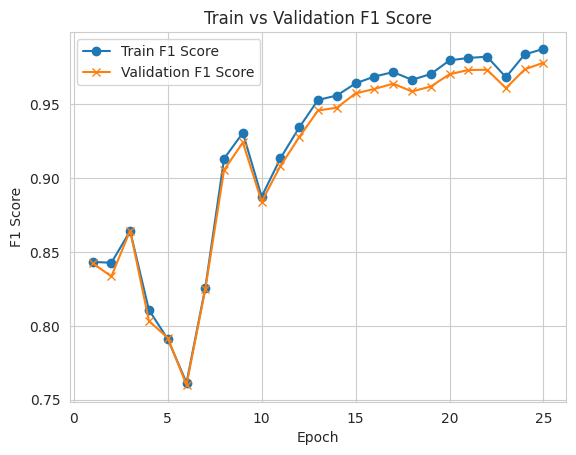

In [21]:
utils.train(lstm_word2vec, train_iter, val_iter,
            lr=1e-3, num_epochs=25, verbose=True)

In [22]:
utils.calculate_metric(lstm_word2vec, test_iter, device="cuda")

0.5569381774421984